# ASSIGNMENT 2
## FOURIER TRANSFORM

In [3]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
from skimage import img_as_float, io, color
from skimage.metrics import peak_signal_noise_ratio as psnr

%matplotlib inline

def imshow_gray(img, title='', vmin=None, vmax=None):
    plt.figure(figsize=(6,6))
    plt.imshow(img, cmap='gray', vmin=vmin, vmax=vmax)
    plt.title(title)
    plt.axis('off')
    plt.show()

def imshow_gray2(img, title='', vmin=None, vmax=None):
    plt.figure(figsize=(6,6))
    plt.subplot(1,2,1)
    plt.imshow(img, cmap='gray', vmin=vmin, vmax=vmax)
    plt.title(title)
    plt.axis('off')
    plt.show()

### LOAD DATA

In [4]:
basedir = 'vehicles'
classes = ['suv', 'hatchback', 'motorcycle', 'pickup', 'sedan']

img_paths = []

for cls in classes:
    cls_dir = os.path.join(basedir, cls)
    if os.path.isdir(cls_dir):
        files = [os.path.join(cls_dir, f) for f in os.listdir(cls_dir) if f.lower().endswith('.jpg')]
        if len(files)>0:
            img_paths.append(files[0])
        else:
            print(f'Advarsel: ingen jpg i {cls_dir}')
    else:
        print(f'Advastserl: mangel {cls_dir}')

print("Valgte bilder:")
for p in img_paths:
    print(p)

Valgte bilder:
vehicles/suv/PIC_21.jpg
vehicles/hatchback/PIC_21.jpg
vehicles/motorcycle/PIC_21.jpg
vehicles/pickup/PIC_202.jpg
vehicles/sedan/PIC_202.jpg


### Load a grayscale image and apply the 2D Discrete Fourier Transform (DFT) to it. Visualize the original image and its frequency spectrum (magnitude). Submit the images, and explanation.

In [5]:
def dft2_gray(img):
    f = np.fft.fft2(img)
    fshift = np.fft.fftshift(f)
    return f, fshift

def magnitude_spectrum(fshift, eps=1e-8):
    mag = np.abs(fshift)
    return np.log(mag + eps)

def plot_image_and_spectrum(img, title=''):
    f, fshift = dft2_gray(img)
    mag = magnitude_spectrum(fshift)
    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1)
    plt.imshow(img, cmap='gray')
    plt.title(title)
    plt.axis('off')
    plt.subplot(1,2,2)
    plt.imshow(mag, cmap='inferno')
    plt.title('Log magnitude spectrum -centerd')
    plt.axis('off')
    plt.show()

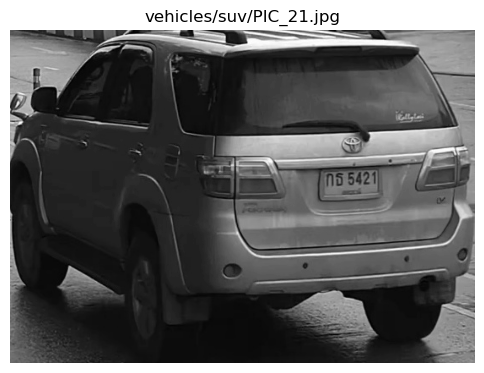

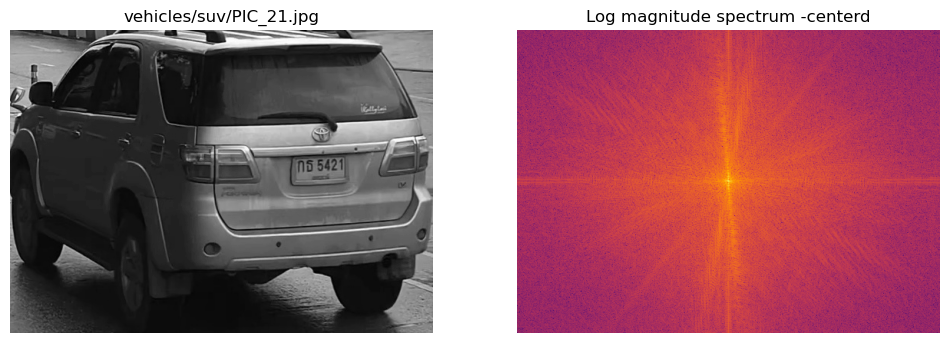

vehicles/suv/PIC_21.jpg


In [6]:
path = img_paths[0]
img_color = cv2.imread(path)
img_gray = cv2.cvtColor(img_color, cv2.COLOR_BGR2GRAY)
img_gray = img_as_float(img_gray)

imshow_gray(img_gray, title=path)
plot_image_and_spectrum(img_gray, title=path)
print(path)

### Implement a low-pass filter in the frequency domain to remove high-frequency noise from an image. Compare the filtered image with the original image. Submit images, and analysis of the results.

In [7]:
def ideal_lowpass_mask(shape, radius):
    rows, cols = shape
    crow, ccol = rows//2, cols//2
    Y, X = np.ogrid[:rows, :cols]
    mask = ((Y - crow)**2 + (X - ccol)**2) <= radius**2
    return mask.astype(float)

def guassian_lowpass_mask(shape, sigma):
    rows, cols = shape
    crow, ccol = rows//2, cols//2
    Y, X = np.ogrid[:rows, :cols]
    dist2 = (Y - crow)**2 + (X - ccol)**2
    mask = np.exp(-dist2/(2*sigma**2))
    return mask

def apply_mask_and_inverse(img, mask):
    f = np.fft.fft2(img)
    fshift = np.fft.fftshift(f)
    fshift_masked = fshift * mask
    f_ishift = np.fft.ifftshift(fshift_masked)
    img_back = np.fft.ifft2(f_ishift)
    img_back = np.real(img_back)
    return img_back

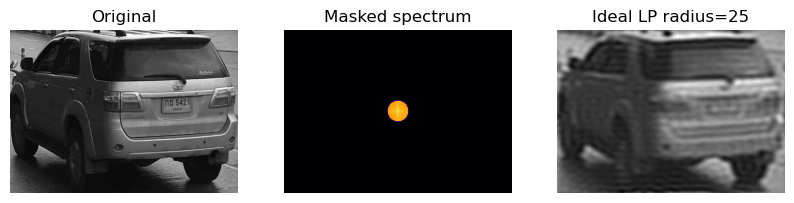

"PSNR original --> filtered: 21.92001920098209


In [8]:
radius = 25
mask = ideal_lowpass_mask(img_gray.shape, radius)
filtered_img = apply_mask_and_inverse(img_gray, mask)

plt.figure(figsize=(10,4))
plt.subplot(1,3,1)
plt.imshow(img_gray, cmap='gray'); plt.title('Original'); plt.axis('off')
plt.subplot(1,3,2)
plt.imshow(magnitude_spectrum(np.fft.fftshift(np.fft.fft2(img_gray))*mask), cmap='inferno'); plt.title('Masked spectrum'); plt.axis('off')
plt.subplot(1,3,3)
plt.imshow(filtered_img, cmap='gray'); plt.title(f'Ideal LP radius={radius}'); plt.axis('off')
plt.show()

print('"PSNR original --> filtered:', psnr(img_gray, np.clip(filtered_img,0,1)))

### Implement a high-pass filter to enhance the edges in an image. Visualize the filtered image and discuss the effects observed. Submit images, and explanation

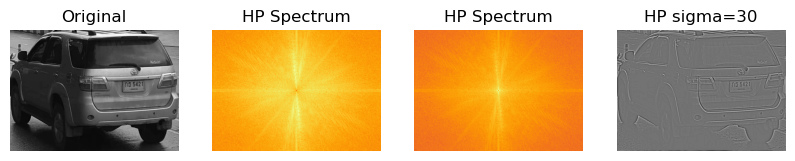

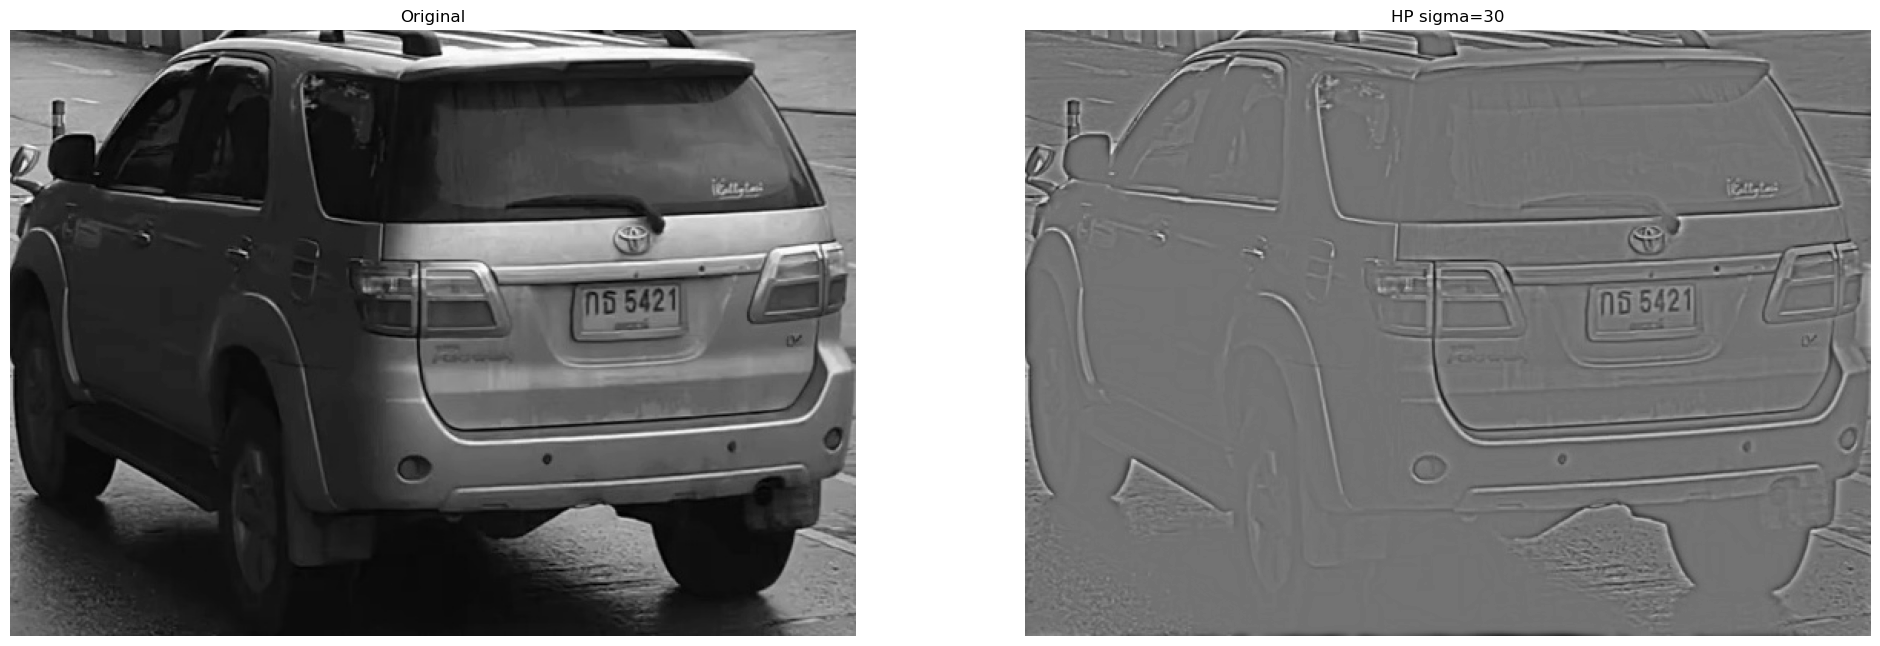

PSNR original->hp (note: hp image is mostly high-freq): 9.63525395267357


In [9]:
sigma = 30
sigmaa = 1
gmask = guassian_lowpass_mask(img_gray.shape, sigma)
ggmask = guassian_lowpass_mask(img_gray.shape, sigmaa)
hmask = 1.0 - gmask
hhmask = 1.0 - ggmask

hp_img = apply_mask_and_inverse(img_gray, hmask)

plt.figure(figsize=(10,4))
plt.subplot(1,4,1); plt.imshow(img_gray, cmap='gray'); plt.title('Original'); plt.axis('off')
plt.subplot(1,4,2); plt.imshow(magnitude_spectrum(np.fft.fftshift(np.fft.fft2(img_gray))*hmask), cmap='inferno'); plt.title('HP Spectrum'); plt.axis('off')
plt.subplot(1,4,3); plt.imshow(magnitude_spectrum(np.fft.fftshift(np.fft.fft2(img_gray))*hhmask), cmap='inferno'); plt.title('HP Spectrum'); plt.axis('off')
plt.subplot(1,4,4); plt.imshow(hp_img, cmap='gray'); plt.title(f'HP sigma={sigma}'); plt.axis('off')
plt.show()

plt.figure(figsize=(24,8))
plt.subplot(1,2,1); plt.imshow(img_gray, cmap='gray'); plt.title('Original'); plt.axis('off')
plt.subplot(1,2,2); plt.imshow(hp_img, cmap='gray'); plt.title(f'HP sigma={sigma}'); plt.axis('off')
plt.show()

print("PSNR original->hp (note: hp image is mostly high-freq):", psnr(img_gray, np.clip(hp_img,0,1)))

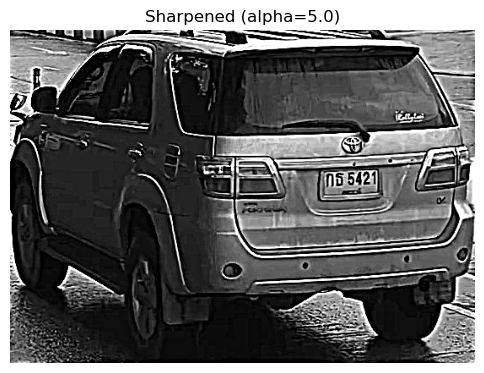

PSNR original->sharpened: 16.8932000557155


In [10]:
#alpha = 100099999999990.0
alpha = 5.0
sharpened = np.clip(img_gray + alpha * hp_img, 0, 1)
imshow_gray(sharpened, title=f"Sharpened (alpha={alpha})")
print("PSNR original->sharpened:", psnr(img_gray, sharpened))

### Implement an image compression technique using Fourier Transform by selectively keeping only a certain percentage of the Fourier coefficients. Evaluate the quality of the reconstructed image as you vary the percentage of coefficients used. Submit the images, and your observations on image quality and compression ratio.

Percent 0.03 -> PSNR: 18.03
Percent 0.5 -> PSNR: 22.24
Percent 1 -> PSNR: 23.58
Percent 10 -> PSNR: 31.20
Percent 50 -> PSNR: 45.63


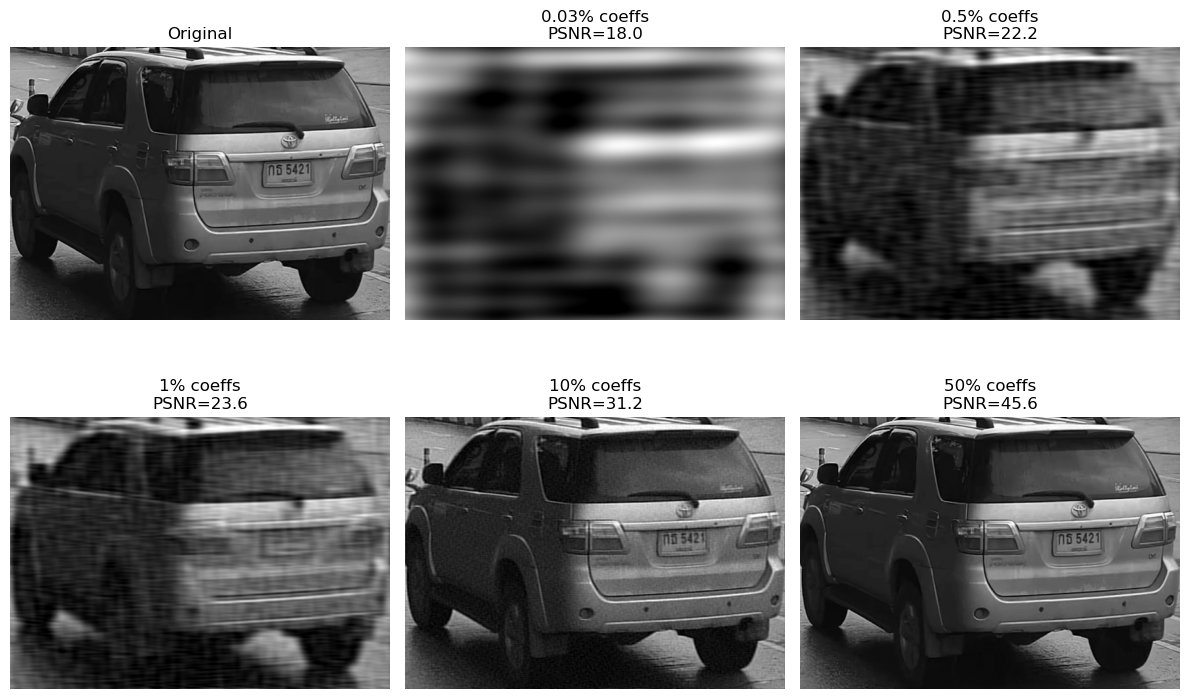

In [11]:
def compress_keep_percent(img, percent):
    f = np.fft.fft2(img)
    fshift = np.fft.fftshift(f)
    mag = np.abs(fshift)
    flat = mag.flatten()
    thresh = np.percentile(flat, 100 - percent)
    mask = (mag>=thresh).astype(float)
    fshift_masked = fshift * mask
    img_rec = np.real(np.fft.ifft2(np.fft.ifftshift(fshift_masked)))
    return img_rec, mask

percents = [0.03, 0.5, 1, 10, 50]
results = []
for p in percents:
    rec, mask = compress_keep_percent(img_gray, p)
    results.append((p, rec, mask))
    print(f"Percent {p} -> PSNR: {psnr(img_gray, np.clip(rec,0,1)):.2f}")

plt.figure(figsize=(12,8))
plt.subplot(2,3,1); plt.imshow(img_gray, cmap='gray'); plt.title('Original'); plt.axis('off')
for i, (p, rec, mask) in enumerate(results[:5], start=2):
    plt.subplot(2,3,i)
    plt.imshow(np.clip(rec,0,1), cmap='gray')
    plt.title(f'{p}% coeffs\nPSNR={psnr(img_gray,np.clip(rec,0,1)):.1f}')
    plt.axis('off')
plt.tight_layout()
plt.show()

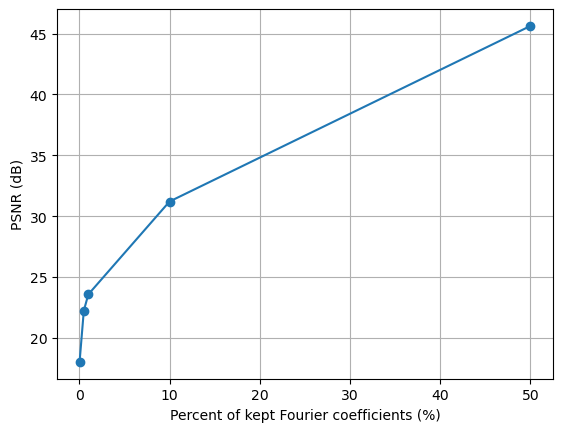

In [12]:
psnrs = [psnr(img_gray, np.clip(rec,0,1)) for (p,rec,mask) in results]
plt.plot([p for (p,_,_) in results], psnrs, marker='o')
plt.xlabel('Percent of kept Fourier coefficients (%)')
plt.ylabel('PSNR (dB)')
plt.grid(True)
plt.show()


# HOG

In [13]:
from skimage.io import imread
from skimage.transform import resize
from skimage.feature import hog
from skimage import exposure

## 1. Write a Python script to compute the HOG features of a given image using a library such as OpenCV or scikit-image.

(225, 309, 3)


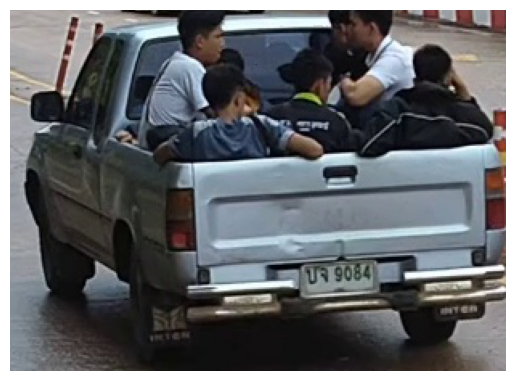

In [14]:
# read the image for HOG
img = imread('vehicles/pickup/PIC_16.jpg')
plt.axis("off")
plt.imshow(img)
print(img.shape)

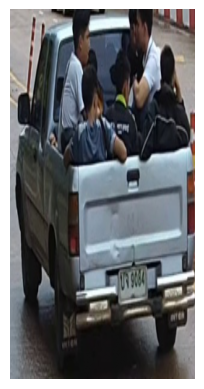

(512, 256, 3)


In [15]:
# resize for HOG
resized_img = resize(img, (128*4, 64*4))
plt.axis("off")
plt.imshow(resized_img)
plt.show()
print(resized_img.shape)

(70308,)
(512, 256)


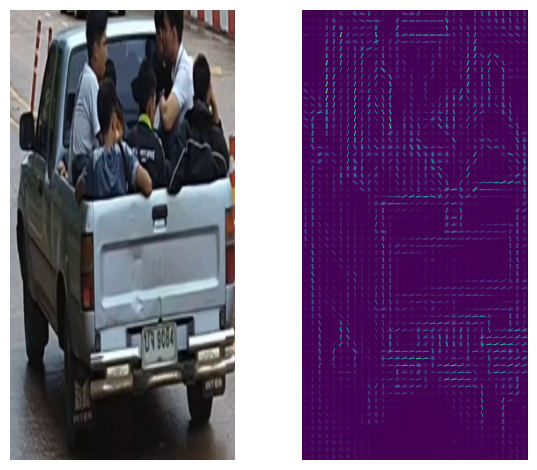

In [16]:
# now let's compute the derivatives in all the directions
fd, hog_image = hog(resized_img, orientations=9, pixels_per_cell=(8, 8), cells_per_block=(2, 2), visualize=True, channel_axis=-1)
print(fd.shape)
print(hog_image.shape)

plt.subplot(1,2,1)
plt.axis("off")
plt.imshow(resized_img)
plt.subplot(1,2,2)
plt.axis("off")
plt.imshow(hog_image)
plt.tight_layout()
plt.show()

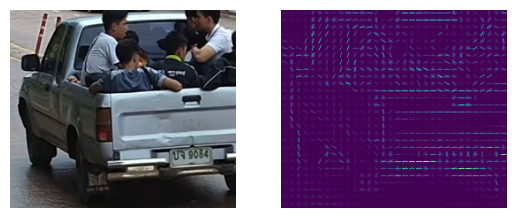

In [17]:
# let's try the HOG for a cropped image
x=0
y=0
h=512
w=256
crop_img = img[y:y+h, x:x+w]
fd_crop_img, hog_crop_img = hog(crop_img, orientations=9, pixels_per_cell=(8, 8),cells_per_block=(2, 2), visualize=True, channel_axis=-1)

plt.subplot(1,2,1)
plt.axis("off")
plt.imshow(crop_img)

plt.subplot(1,2,2)
plt.axis("off")
plt.imshow(hog_crop_img)

plt.show()

In [18]:
import matplotlib.pyplot as plt
from skimage.feature import hog
from skimage import data, exposure, color

In [19]:
image_gray = color.rgb2gray(img)

fd, hog_image = hog(
    image_gray,
    orientations=8,
    pixels_per_cell=(16, 16),
    cells_per_block=(1, 1),
    visualize=True,
    channel_axis=None # Specify channel_axis for multi-channel images
)

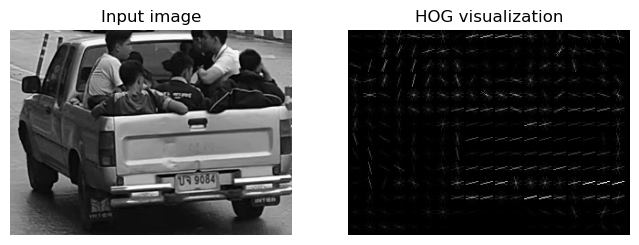

In [20]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4), sharex=True, sharey=True)

ax1.axis('off')
ax1.imshow(image_gray, cmap=plt.cm.gray)
ax1.set_title('Input image')

# Rescale the HOG visualization for better contrast
hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 10))

ax2.axis('off')
ax2.imshow(hog_image_rescaled, cmap=plt.cm.gray)
ax2.set_title('HOG visualization')
plt.show()

In [21]:
print(f"HOG feature vector shape: {fd.shape}")

HOG feature vector shape: (2128,)


## CHAT

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.feature import hog
from skimage import exposure

def compute_hog_features(image_path, visualize=True):
    """
    Beregner HOG-features for et gitt bilde med et 64x128 deteksjonsvindu,
    8x8 piksels celler, 2x2 celler per blokk (50% overlapp), og 9 bins.
    
    Parametere:
        image_path (str): Filstien til bildet
        visualize (bool): Hvis True, viser original, gråskala og HOG-bilde
    
    Returnerer:
        features (np.ndarray): HOG feature-vektor
        hog_image_rescaled (np.ndarray): Visualisering (bare hvis visualize=True)
    """

    # --- 1. Les inn bilde og konverter til gråskala ---
    image = cv2.imread(image_path)
    if image is None:
        raise FileNotFoundError(f"Kunne ikke lese bilde: {image_path}")
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # --- 2. Resizer bildet til 64x128 (standard deteksjonsvindu) ---
    resized = cv2.resize(gray, (64*4, 128*4))

    # --- 3. Beregn HOG-features ---
    features, hog_image = hog(
        resized,
        orientations=9,               # 9 retninger (0–180 grader)
        pixels_per_cell=(8, 8),       # Hver celle er 8x8 piksler
        cells_per_block=(2, 2),       # Hver blokk = 2x2 celler
        block_norm='L2-Hys',          # Normalisering
        transform_sqrt=True,          # Kontrastnormalisering
        visualize=True,
        feature_vector=True
    )

    # --- 4. Forsterk kontrasten i HOG-bildet ---
    hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 10))
    hog_image_rescaled = exposure.adjust_gamma(hog_image_rescaled, gamma=0.5)

    # --- 5. Visualisering (valgfritt) ---
    if visualize:
        fig, axes = plt.subplots(1, 3, figsize=(14, 6))
        axes[0].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        axes[0].set_title('Original')
        axes[0].axis('off')

        axes[1].imshow(resized, cmap='gray')
        axes[1].set_title('Grayscale (64x128)')
        axes[1].axis('off')

        axes[2].imshow(hog_image_rescaled, cmap='inferno')
        axes[2].set_title('HOG-visualisering (forsterket)')
        axes[2].axis('off')

        plt.tight_layout()
        plt.show()

    print(f"[INFO] HOG feature vector length: {len(features)}")
    return features, hog_image_rescaled


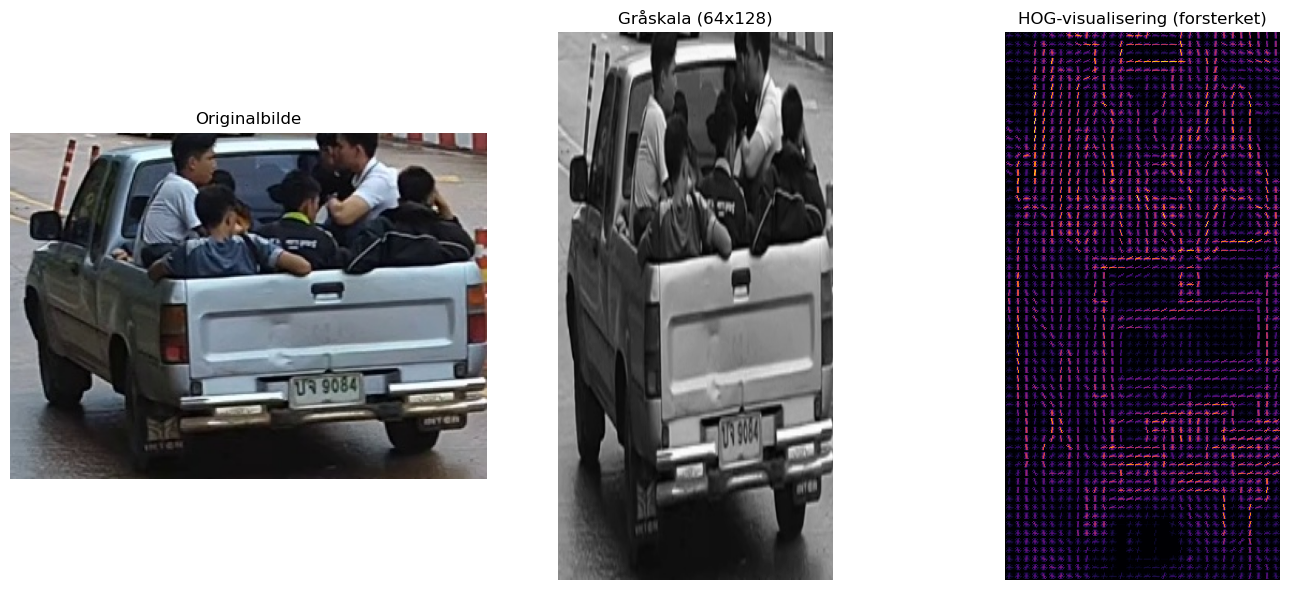

[INFO] HOG feature vector length: 70308


In [37]:
features, hog_img = compute_hog_features('vehicles/pickup/PIC_16.jpg', visualize=True)

## N***

In [35]:
def hog_features_from_img(img):
    image = imread(img)
    if image is None:
        raise FileNotFoundError(f"Kunne ikke lese bilde: {img}")
    image = resize(image, (128*4, 64*4))
    print(image.shape)

    # 2. Compute HOG features and optional visualization
    # The hog() function returns the feature vector (fd) and optionally a visualization image (hog_image)
    # We set visualize=True to get the visualization.
    fd, hog_image = hog(
        image,
        orientations=9,
        pixels_per_cell=(8, 8),
        cells_per_block=(2, 2),
        visualize=True,
        channel_axis=-1  # Specify channel axis for color images
    )

    # 3. Visualize the results
    # The 'hog_image' is a representation of the HOG features, but its intensity range
    # might need to be rescaled for better display.
    hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 10))

    # Create a subplot to display the original image and the HOG features
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 8), sharex=True, sharey=True)

    # Display the original image
    ax1.axis('off')
    ax1.imshow(image, cmap=plt.cm.gray)
    ax1.set_title('Original Image')

    # Display the HOG features visualization
    ax2.axis('off')
    ax2.imshow(hog_image_rescaled, cmap=plt.cm.gray)
    ax2.set_title('HOG Features')

    plt.show()

    # The 'fd' variable now holds the flattened HOG feature vector
    print(f"Shape of the HOG feature vector: {fd.shape}")
    print("First 10 HOG features:", fd[:10])
    return fd, hog_image

(128, 64, 3)


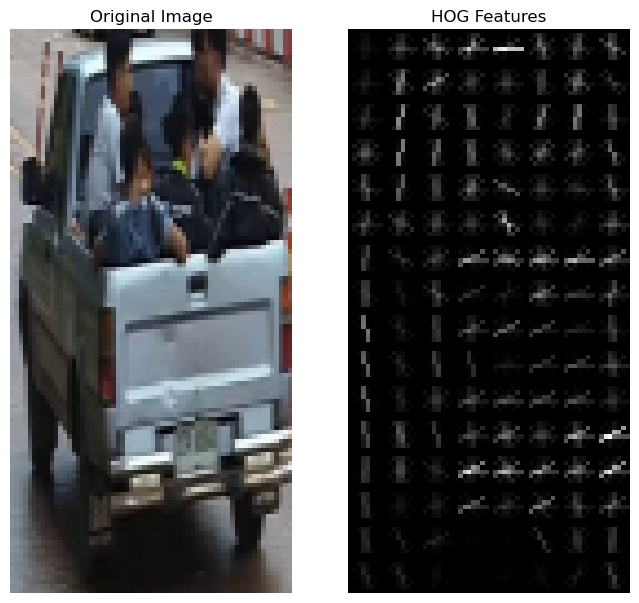

Shape of the HOG feature vector: (3780,)
First 10 HOG features: [0.16326963 0.00980355 0.01182762 0.03658948 0.07314811 0.01952703
 0.05562319 0.02431455 0.13180557 0.3190238  0.16966524 0.06042994
 0.10831702 0.3190238  0.27381383 0.01871284 0.06581188 0.31417882
 0.20563089 0.06904352 0.         0.05626647 0.13379854 0.01765539
 0.07698918 0.03408428 0.13169713 0.3190238  0.3190238  0.08365972]


In [31]:
img = 'vehicles/pickup/PIC_16.jpg'
fd, hogimg = hog_features_from_img(img)

## 2. Apply your implementation to at least three different images, including both simple and complex scenes

(512, 256, 3)


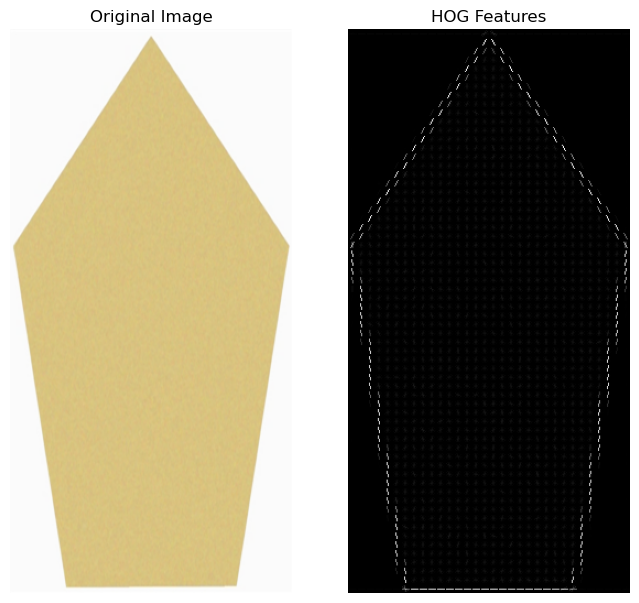

Shape of the HOG feature vector: (70308,)
First 10 HOG features: [0.27792305 0.         0.         0.36445547 0.55609943 0.07989612
 0.         0.         0.08964323 0.        ]
(512, 256, 3)


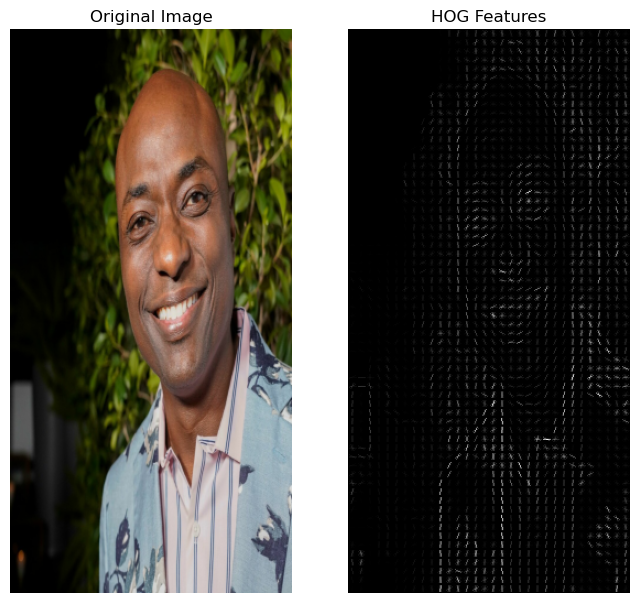

Shape of the HOG feature vector: (70308,)
First 10 HOG features: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
(512, 256, 3)


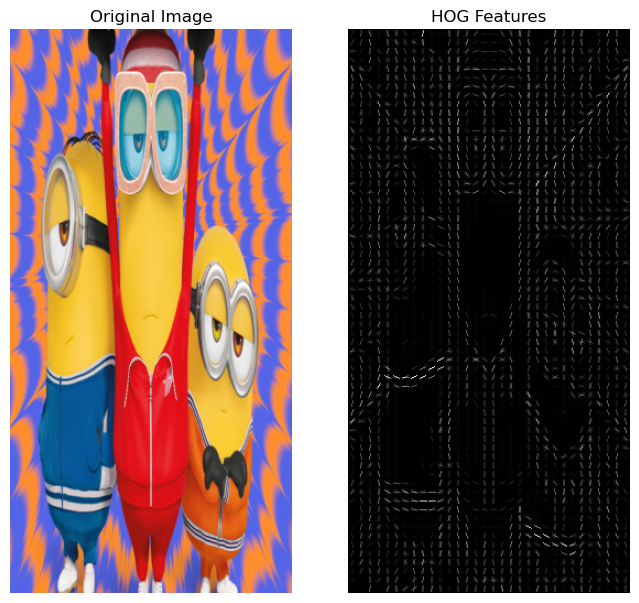

Shape of the HOG feature vector: (70308,)
First 10 HOG features: [0.42449321 0.00077621 0.         0.00241514 0.0033299  0.
 0.00109386 0.         0.00901576 0.42449321]


In [39]:
img1 = 'simple_shape.jpg'
img2 = 'face.jpg'
img3 = 'minions.jpg'
fd1, hog1 = hog_features_from_img(img1)
fd2, hog2 = hog_features_from_img(img2)
fd3, hog3 = hog_features_from_img(img3)

In [27]:
## 2

## 3. Visualize the original image, the gradient image, and the HOG feature image

In [28]:
## 3

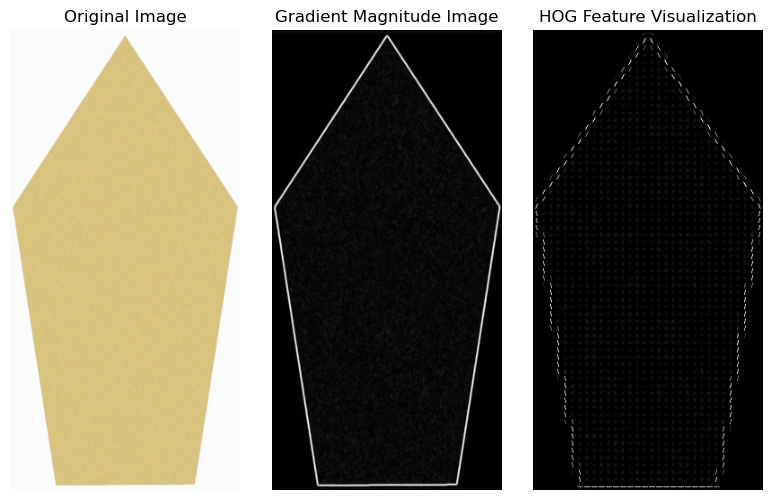

HOG feature vector length: 70308


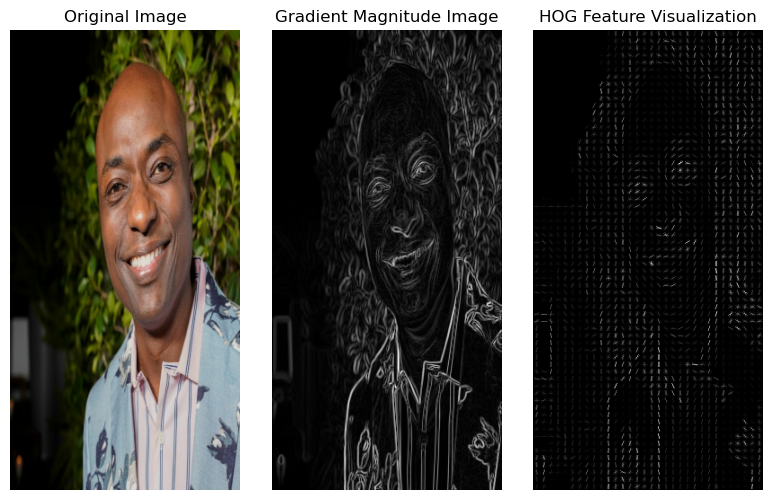

HOG feature vector length: 70308


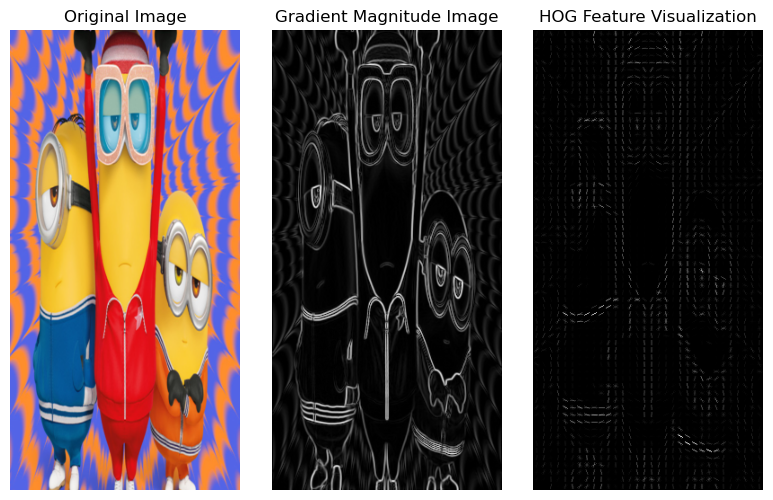

HOG feature vector length: 70308


In [46]:
import cv2
import matplotlib.pyplot as plt
from skimage.feature import hog
from skimage import exposure
from skimage.color import rgb2gray

def visualize_hog(img_path):
    # 1. Read image
    image = cv2.imread(img_path)
    image = resize(image, (128*4, 64*4))
    image = (image * 255).astype("uint8") 
    if image is None:
        raise FileNotFoundError(f"Could not read image: {img_path}")
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    

    # 2. Convert to grayscale for gradient/HOG
    gray = rgb2gray(image_rgb)

    # 3. Compute gradients
    grad_x = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=3)
    grad_y = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=3)
    gradient_magnitude = cv2.magnitude(grad_x, grad_y)

    # 4. Compute HOG features + visualization
    fd, hog_image = hog(
        gray,
        orientations=9,
        pixels_per_cell=(8, 8),
        cells_per_block=(2, 2),
        block_norm='L2-Hys',
        visualize=True,
        transform_sqrt=True
    )

    # 5. Rescale the HOG image for better visibility
    hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 10))

    # 6. Plot all images
    fig, axes = plt.subplots(1, 3, figsize=(8, 5))
    axes[0].imshow(image_rgb)
    axes[0].set_title("Original Image")
    axes[0].axis("off")

    axes[1].imshow(gradient_magnitude, cmap="gray")
    axes[1].set_title("Gradient Magnitude Image")
    axes[1].axis("off")

    axes[2].imshow(hog_image_rescaled, cmap="gray")
    axes[2].set_title("HOG Feature Visualization")
    axes[2].axis("off")

    plt.tight_layout()
    plt.show()

    print(f"HOG feature vector length: {len(fd)}")

# Example usage:
visualize_hog(img1)
visualize_hog(img2)
visualize_hog(img3)


## 4. Compare the HOG features extracted from different images. Discuss the impact of varying parameters like cell size, block size, and the number of bins on the resulting HOG descriptors.

In [29]:
## 4